In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from dtaidistance import dtw

# 1. 데이터 로드 & 전처리

In [10]:
# UCI의 Beijing PM2.5 Data (2010~2014)를 사용합니다.
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"
air_df = pd.read_csv(url)

In [11]:
# 년, 월, 일, 시간을 하나의 datetime 컬럼으로 합치기
air_df['date_time'] = pd.to_datetime(air_df[['year', 'month', 'day', 'hour']])
air_df = air_df.sort_values(by='date_time')

In [12]:
# 데이터프레임 일부 확인
print('데이터 샘플:')
print(air_df.head())

데이터 샘플:
   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir  \
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0   
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0   
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0   
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0   
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0   

            date_time  
0 2010-01-01 00:00:00  
1 2010-01-01 01:00:00  
2 2010-01-01 02:00:00  
3 2010-01-01 03:00:00  
4 2010-01-01 04:00:00  


# 2. 이상치 탐지 (Isolation Forest)

In [13]:
# 센서 컬럼 예시: pm2.5, TEMP(온도), DEWP(이슬점 -> 습도 관련 정보)
features = ['pm2.5', 'TEMP', 'DEWP']
# 결측치는 각 컬럼의 평균값으로 대체
X = air_df[features].fillna(air_df[features].mean())

In [14]:
# Isolation Forest 모델 생성 (전체 데이터의 1%를 이상치로 가정)
iso_forest = IsolationForest(contamination=0.01, random_state=42)
air_df['anomaly_flag'] = iso_forest.fit_predict(X)  # -1: 이상치, 1: 정상

print("\n이상치 탐지 결과 (flag 값):")
print(air_df['anomaly_flag'].value_counts())


이상치 탐지 결과 (flag 값):
anomaly_flag
 1    43385
-1      439
Name: count, dtype: int64


# 3. 시계열 패턴 분석 (DTW)

In [18]:
# 예시로 PM2.5 시계열의 두 구간(각 100 포인트)의 유사도를 측정합니다.
series_a = X['pm2.5'].iloc[:100].values
series_b = X['pm2.5'].iloc[100:200].values

distance = dtw.distance(series_a, series_b)
print('\n두 구간의 DTW distance:', distance)


두 구간의 DTW distance: 655.6157948889023


# 4. 결과 시각화: PM2.5 시계열 그래프에 이상치(Anomaly)를 빨간 점으로 표시

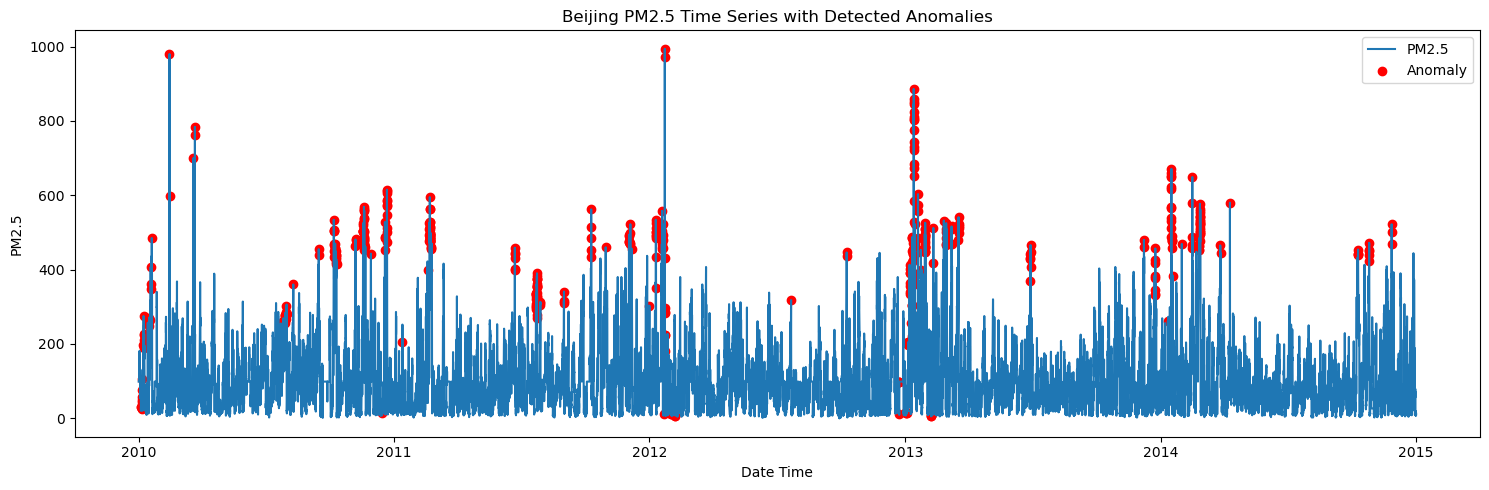

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(air_df['date_time'], X['pm2.5'], label='PM2.5')
plt.scatter(air_df.loc[air_df['anomaly_flag']==-1, 'date_time'],
            X.loc[air_df['anomaly_flag']==-1, 'pm2.5'],
            color='red', label='Anomaly')
plt.xlabel('Date Time')
plt.ylabel('PM2.5')
plt.title('Beijing PM2.5 Time Series with Detected Anomalies')
plt.legend()
plt.tight_layout()
plt.show()

# 결과 해석
- 데이터 샘플에서 PM2.5 값이 결측되어 있는 경우가 많으며, 결측값은 평균으로 대체되었습니다.
- 이상치 탐지 결과, 약 43,824개의 데이터 중 439개의 데이터가 이상치(-1)로 분류되었습니다. 이는 모델이 전체 데이터의 1%를 이상치로 가정한 contamination 설정과 부합합니다.
- DTW 거리는 두 구간의 시계열 패턴 차이를 수치로 나타내며, 655.62 정도의 거리가 산출되었습니다. 이 값은 두 시계열 구간 간의 패턴 차이가 어느 정도 있음을 시사합니다.